# Scoring notebook

This is the scoring notebook for the data driven competition at CMF 2022. You can change cells with `### YOUR CODE HERE` line, all other cells are read-only. However, you can add new cells to organize your code in a convenient way.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

Let us load the dataset. Columns in the test (public as well as private) dataset are equivalent to the train dataset.

In [2]:
dataset = pd.read_csv('train.csv', index_col=0, header=[0, 1])



dataset.rename(
    columns={
        'Unnamed: 209_level_1': 'count',
        'Unnamed: 210_level_1': 'price',
    },
    level = 1,
    inplace = True
)
dataset.head()

timestamp_second bid_price_0                                                \
                     nunique       mean   median       std     min     max   
0                          7  44.183379  44.1865  0.007340  44.171  44.190   
1                          1  44.190000  44.1900  0.000000  44.190  44.190   
2                          3  44.187467  44.1860  0.001767  44.186  44.190   
3                          3  44.181038  44.1860  0.006993  44.173  44.188   
4                          2  44.213095  44.2190  0.012474  44.188  44.219   

timestamp_second                 bid_quantity_0          ...  \
                   first    last            sum nunique  ...   
0                 44.171  44.190        25880.7       5  ...   
1                 44.190  44.190           76.7       1  ...   
2                 44.190  44.186          597.5       3  ...   
3                 44.186  44.188         2062.8       2  ...   
4                 44.188  44.219         6350.8       2  ...   

timestamp_second sell_trade_quantity                                    count  \
                             nunique mean median std min max first last count   
0                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    66   
1                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    13   
2                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    15   
3                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    52   
4                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    21   

timestamp_second    price  
                    price  
0                 44.2005  
1                 44.2195  
2                 44.2195  
3                 44.2175  
4                 44.2060  

[5 rows x 210 columns]

In [3]:
class Dataloader():
    def __init__(
        self, 
        dataframe: pd.DataFrame, 
        window_size: int, 
        step_size: int,
        horizon: int,
        first_pred: int
    ):
        self.df = dataframe
        self.window_size = window_size
        self.step_size = step_size
        self.horizon = horizon
        self.first_pred = first_pred
        assert self.first_pred > self.window_size
        feat_idx = []
        target_idx = []
        for i in range(self.first_pred, self.df.shape[0], self.step_size):
            feat_idx.append(range(i-self.horizon-self.window_size+1, i-self.horizon+1))
            target_idx.append(i)
        self.feat_idx = feat_idx
        self.target_idx = target_idx
    
    def __len__(self):
        return len(self.feat_idx)
    
    def __iter__(self):
        self.iter = 0
        return self

    def __next__(self):
        if self.iter < len(self.feat_idx):
            feat = self.df.iloc[self.feat_idx[self.iter]]
            target = self.df.iloc[self.target_idx[self.iter], -1]
            self.iter += 1
            return feat, target
        else:
            raise StopIteration

Column **price** represents the price at moment **t**. The task is to predict **price** values at moment **t+60**.

The forecasting problem is defined as follows. Consider the multivariate time series of features (exogenous variables) $X_0, X_1, \dots $ where $X_i \in \mathbb{R}^d$. Consider the univariate time series of targets (endogenous variables) $y_0, y_1, ...$ where $y_i \in \mathbb{R}$. The task is to predict the $y_{T+h}$ where $T \in \{1000, 1001, \dots\}$ is the last available time stamp and $h = 60$ is the forecasting horizon by the given _sliding window_ over pairs $(X, y)_{T-N+1}, (X, y)_{T-N+2}, \dots, (X, y)_T$ with the selected window size $1 \leq N \leq 1000$. The optimization problem is minimizing the mean squared error between predictions and targets.

Select the window size appropriately to your solution.

In [4]:
window_size = 1000
import warnings
warnings.filterwarnings("ignore")



def precess_1000(data):
    df = data[0:40]
    min_data_2 = pd.DataFrame(get_dict_row(df), index=[0])
    i = 0
    while df.empty == False:
        df = data[40 + i*60 : 40 + (i+1)*60]
        if df.empty == False:
            min_data_2 = min_data_2.append(get_dict_row(df), ignore_index=True)  
        i+=1
    last_sec_price = data.iloc[-1].price 
    
    return min_data_2 , last_sec_price 

def get_dict_row(part_data):
    dsts_lst = {}
    for i in range(5):

        dsts_lst['bid_price' + str(i) + '_weighted'] = ((part_data["bid_price_" + str(i)]  *
                         part_data["bid_quantity_" + str(i)]).sum(axis=0)  / 
                         part_data["bid_quantity_" + str(i)].sum(axis=0))

        dsts_lst['ask_price' + str(i) + '_weighted'] = ((part_data["ask_price_" + str(i)]  *
                         part_data["ask_quantity_" + str(i)]).sum(axis=0)  / 
                         part_data["ask_quantity_" + str(i)].sum(axis=0))
        
        dsts_lst["ask_quantity_" + str(i)] = part_data["ask_quantity_" + str(i)].sum(axis=0)
        dsts_lst["bid_quantity_" + str(i)] = part_data["bid_quantity_" + str(i)].sum(axis=0)



    dsts_lst['buy_trade_price'] = (part_data.buy_trade_price * part_data.buy_trade_quantity).sum(axis=0) /  part_data.buy_trade_quantity.sum(axis=0)
    dsts_lst['buy_trade_quantity'] = (part_data.buy_trade_quantity.sum(axis=0))

    dsts_lst['sell_trade_price'] = ((part_data.sell_trade_price * part_data.sell_trade_quantity).sum(axis=0) /  part_data.sell_trade_quantity.sum(axis=0))
    dsts_lst['sell_trade_quantity'] = (part_data.sell_trade_quantity.sum(axis=0))


    dsts_lst['count'] = (part_data['count'].sum(axis=0))
    dsts_lst['price'] = part_data['price'].mean()
    
    return dsts_lst


def get_features_and_last_sec_price(df , last_sec_price):
    feachers = {}

    price_bid =   (df.iloc[-1]['bid_price0_weighted'] * df.iloc[-1]['bid_quantity_0'] +
                   df.iloc[-1]['bid_price1_weighted'] * df.iloc[-1]['bid_quantity_1'] +
                   df.iloc[-1]['bid_price2_weighted'] * df.iloc[-1]['bid_quantity_2'] +    
                   df.iloc[-1]['bid_price3_weighted'] * df.iloc[-1]['bid_quantity_3'] +        
                   df.iloc[-1]['bid_price4_weighted'] * df.iloc[-1]['bid_quantity_4'])/(
                   df.iloc[-1]['bid_quantity_0'] + df.iloc[-1]['bid_quantity_1'] +
                   df.iloc[-1]['bid_quantity_2'] + df.iloc[-1]['bid_quantity_3'] +
                   df.iloc[-1]['bid_quantity_4'])

    price_ask =   (df.iloc[-1]['ask_price0_weighted'] * df.iloc[-1]['ask_quantity_0'] +
                   df.iloc[-1]['ask_price1_weighted'] * df.iloc[-1]['ask_quantity_1'] +
                   df.iloc[-1]['ask_price2_weighted'] * df.iloc[-1]['ask_quantity_2'] +    
                   df.iloc[-1]['ask_price3_weighted'] * df.iloc[-1]['ask_quantity_3'] +        
                   df.iloc[-1]['ask_price4_weighted'] * df.iloc[-1]['ask_quantity_4'])/(
                   df.iloc[-1]['ask_quantity_0'] + df.iloc[-1]['ask_quantity_1'] +
                   df.iloc[-1]['ask_quantity_2'] + df.iloc[-1]['ask_quantity_3'] +
                   df.iloc[-1]['ask_quantity_4'])

    
    feachers['bias'] = 1
    feachers['delta_price_3day'] = df.price.iloc[-1] - df.price.iloc[-3]
    feachers['std_price'] = df.price.std()
    feachers['sell_trade_quantity'] = df.sell_trade_quantity.sum()
    feachers['buy_trade_quantity'] = df.buy_trade_quantity.sum()
    feachers['count'] = df['count'].sum()
    feachers['last_min_spread'] = price_ask - price_bid
    feachers['last_sec_price'] = last_sec_price
    feachers['bid_1_2_last_5min'] = (df.tail(5)['bid_quantity_0'] + df.tail(5)['bid_quantity_1']).sum()
    feachers['ask_1_2_last_5min'] = (df.tail(5)['ask_quantity_0'] + df.tail(5)['ask_quantity_1']).sum()

    return feachers

def get_X_y_row(data_1060):
    
    df , last_sec_price  = precess_1000(data_1060[0:1000])
    X = get_features_and_last_sec_price(df , last_sec_price)
    y = data_1060.price.iloc[-1]
    
    res_df = pd.DataFrame(X, index=[0])
    res_df['price_to_predict'] = y

    return res_df
        
    
def norm_X(X):
    return (X-X.mean ())/X.std()


def data_processing(dataset):
    df = pd.DataFrame()
    a = (dataset[i*1060 : (i+1)*1060] for i in range(dataset.shape[0]//1600))
    
    for data_1060 in a:
            df = df.append(get_X_y_row(data_1060))
            
    return df

def multi_index_pop(df):
    lst_qq = [('bid_price_0',   'mean'),
                ('bid_price_1',   'mean'),
                ('bid_price_2',   'mean'),
                ('bid_price_3',   'mean'),
                ('bid_price_4',   'mean'),

                ('bid_quantity_0',   'mean'),
                ('bid_quantity_1',   'mean'),
                ('bid_quantity_2',   'mean'),
                ('bid_quantity_3',   'mean'),
                ('bid_quantity_4',   'mean'),


                ('ask_price_0',   'mean'),
                ('ask_price_1',   'mean'),
                ('ask_price_2',   'mean'),
                ('ask_price_3',   'mean'),
                ('ask_price_4',   'mean'),

                ('ask_quantity_0',   'mean'),
                ('ask_quantity_1',   'mean'),
                ('ask_quantity_2',   'mean'),
                ('ask_quantity_3',   'mean'),
                ('ask_quantity_4',   'mean'),

                ('buy_trade_price',   'mean'),
                ('buy_trade_quantity',   'mean'),
                ('sell_trade_price',   'mean'),
                ('sell_trade_quantity',   'mean'),

                (      'count',   'count'),
                (      'price',   'price')]
    df = df[lst_qq]
    df.columns = df.columns.droplevel(1)
    return df

def precess_1000(data):
    df = data[0:40]
    min_data_2 = pd.DataFrame(get_dict_row(df), index=[0])
    i = 0
    while df.empty == False:
        df = data[40 + i*60 : 40 + (i+1)*60]
        if df.empty == False:
            min_data_2 = min_data_2.append(get_dict_row(df), ignore_index=True)  
        i+=1
    last_sec_price = data.iloc[-1].price 
    
    return min_data_2 , last_sec_price 

def feat_to_X(ft):
    data_hz , last_sec_price = precess_1000(multi_index_pop(feat))
    X_nope = get_features_and_last_sec_price(data_hz , last_sec_price)
    X = pd.DataFrame(X_nope, index=[0])
    return X


import gdown
import torch

url = 'https://drive.google.com/file/d/1LEHQKTdUjh3CpoFnadZu3rW8992v3f1f/view?usp=share_link'
gdown.download(url, 'model_scripted.pt', fuzzy=True)
loaded_model  = torch.load('model_scripted.pt')



Downloading...
From: https://drive.google.com/uc?id=1LEHQKTdUjh3CpoFnadZu3rW8992v3f1f
To: /Users/rs/Documents/data-driven project2/model_scripted.pt
100%|███████████████████████████████████████| 1.28k/1.28k [00:00<00:00, 214kB/s]


In [5]:
assert (1 <= window_size) and (window_size <= 1000)

The dataloader defines the forecasting problem with the selected window size.

**Remark**: first 1060 observations in both test datasets will not be scored.

In [6]:
loader = Dataloader(
    dataframe=dataset, 
    window_size=window_size, 
    step_size=10600, 
    horizon=60, 
    first_pred=1060)

for feat, target in loader:
    break
feat.shape, target

((1000, 210), 44.0695)

Define your forecasting model. You can install necessary libraries by `!pip install ... `. You can find installed packages in [requirements](https://github.com/vpozdnyakov/EvalAI/blob/master/requirements/worker.txt). Here is also CPU version of `torch==1.10.2`. Do not train the model here, instead download the weights of a pretrained model from your own cloud service, e.g. google drive by `gdown` as follows:

```python
!pip install gdown==4.2.0 -q
url = ...
gdown.download(url, 'model_scripted.pt', fuzzy=True)
model = torch.jit.load('model_scripted.pt')
```

You can change the template by adding additional methods, parameters, etc.

In [7]:
class ForecastingModel():
    # Naive forecasting model
    def __init__(self):
        pass
    def forecast(self, feat):
        return feat.iloc[-1, -1]

model = ForecastingModel()

In **forecast** function you can do preprocessing, e.g. deletion unnecessary data or aggregation.

In [8]:
def forecast(feat):
    feat_to_X(feat)    
    return feat_to_X(feat).dot(loaded_model.coef_.T)

Scoring the model.

In [59]:
pred = []
target = []
for feat, _target in loader:
    pred.append(forecast(feat))
    target.append(_target)
mse(pred, target)

0.005389959310342392

Let us draw the forecast visualization.

Example of 1000 forecasts.

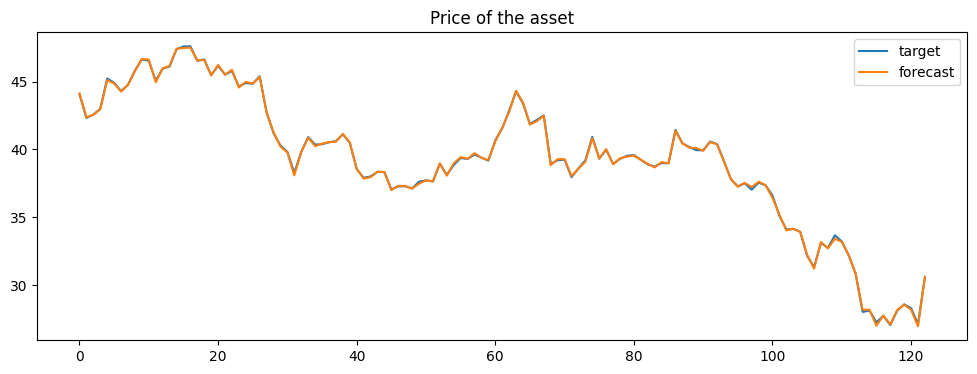

In [60]:
plt.figure(figsize=(12, 4))
plt.plot(target, label='target')
plt.plot(pred, label='forecast')
plt.title('Price of the asset')
plt.legend()
plt.show()

In [174]:
df_test = pd.DataFrame({'actual_price': target, 'predicted_price': [x.values[0] for x in pred]}, columns=['actual_price', 'predicted_price'])
df_test

,actual_price,predicted_price
0,44.0695,44.134494
1,42.3275,42.374340
2,42.5725,42.553036
3,42.9995,42.965671
4,45.2285,45.111639
...,...,...
118,28.1120,28.158906
119,28.5730,28.551952
120,28.2905,28.180633
121,27.1220,26.958456


# Стратегия на основе предсказаний

In [217]:
import seaborn as sns
import matplotlib.pyplot as plt
import quantstats as qs
import warnings
import numpy as np

warnings.filterwarnings("ignore")

class StockStrategy:
    
    def __init__(self, df, threshold_buy=0, threshold_sell=0, portfl=1000, ticker_num=0):
        self.df = df
        self.df = self.df.reset_index(drop=False)
        self.threshold_buy = threshold_buy
        self.threshold_sell = threshold_sell
        self.portfl = portfl
        self.ticker_num = ticker_num
        self.percent_guess = 0
        self.strategy_profit = None
        self.last_trade_portfl = portfl


        
        
        self.df["predicted_price_change"] = self.df.predicted_price - self.df.actual_price.shift(1)
        self.df["real_price_change"] = self.df.actual_price - self.df.actual_price.shift(1)
        self.df["GUESS_true_false"] = np.sign(self.df["real_price_change"]) == np.sign(self.df["predicted_price_change"])
        
        self.df["Market (Buy and Hold Strategy)"] = self.portfl * self.df.actual_price / self.df.actual_price[0]
        self.df["predicted_price_change"] = self.df.predicted_price - self.df.actual_price.shift(1)
        self.df["real_price_change"] = self.df.actual_price - self.df.actual_price.shift(1)
        self.df["GUESS_true_false"] = np.sign(self.df["real_price_change"]) == np.sign(self.df["predicted_price_change"])
               
            
        self.df["trade_quantity"] = None
        self.df["side"] = None
        self.df["pnl"] = None




    def strategy_test(self):

        self.percent_guess = round(len(self.df[self.df.GUESS_true_false == True]) / len(self.df) * 100, 1)

        for i in range(1, self.df.shape[0]):
            # buy signal    
            if self.df.predicted_price_change.iloc[i] > self.threshold_buy and self.portfl != 0:
                self.ticker_num = self.portfl / self.df.iloc[i].actual_price
                self.df.loc[i, 'side'] = 'buy'
                self.last_trade_portfl = self.portfl
                self.df.loc[i, 'trade_quantity'] = self.portfl
                self.portfl = 0




            # sell signal
            if self.df.predicted_price_change.iloc[i] < -self.threshold_sell and self.ticker_num != 0:
                self.portfl = self.ticker_num * self.df.iloc[i].actual_price
                self.df.loc[i, 'side'] = 'sell'

                self.df.loc[i, 'pnl'] = self.portfl - self.last_trade_portfl
                self.df.loc[i, 'trade_quantity'] = self.portfl
                self.ticker_num = 0





            self.df.loc[i, 'ticker_num'] = self.ticker_num
            self.df.loc[i, 'portfl'] = self.portfl







        self.df["Strategy"] = self.df.portfl + self.df.ticker_num * self.df.actual_price
        self.df["Strategy"].iloc[0] = self.df["Strategy"].iloc[1]

        self.strategy_profit = self.df[["Market (Buy and Hold Strategy)", 'Strategy', 'side', 'trade_quantity', 'pnl']]
        
        return self.strategy_profit
    
    def plot_strategy(self, name = "Fuzzy strategy"):
        self.strategy_profit[["Market (Buy and Hold Strategy)", 'Strategy']].plot(grid=True, figsize=(14, 9))
        plt.title(name)
        plt.xlabel("Date")
        plt.ylabel("Profit, US$")
        
        
    def basic_metrics(self):
        profit = self.strategy_profit[["Market (Buy and Hold Strategy)", 'Strategy']]
        print(f'Cumulative return:\n{round(((profit.iloc[-1] - profit.iloc[0])/profit.iloc[0])*100,2).to_string()}\n')
        print(f'Sharpe ratio:\n{qs.stats.sharpe(profit).to_string()}\n')
        print(f'Max markdown:\n{round(qs.stats.max_drawdown(profit)*100,2).to_string()}\n')




In [222]:
strategy_tester = StockStrategy(df_test, portfl=100, threshold_buy = 1, threshold_sell = 0)
strategy_tester.strategy_test().head(25)

,Market (Buy and Hold Strategy),Strategy,side,trade_quantity,pnl
0,100.000000,100.000000,None,None,None
1,96.047153,100.000000,None,None,None
2,96.603093,100.000000,None,None,None
3,97.572017,100.000000,None,None,None
4,102.629937,100.000000,buy,100,None
5,101.928772,99.316802,sell,99.316802,-0.683198
6,100.526441,99.316802,None,None,None
7,101.586131,99.316802,None,None,None
8,103.976673,99.316802,buy,99.316802,None
9,105.836236,101.093026,None,None,None


Cumulative return:
Market (Buy and Hold Strategy)   -30.55
Strategy                           0.01

Sharpe ratio:
Market (Buy and Hold Strategy)   -1.450601
Strategy                          0.063181

Max markdown:
Market (Buy and Hold Strategy)   -43.19
Strategy                          -9.20



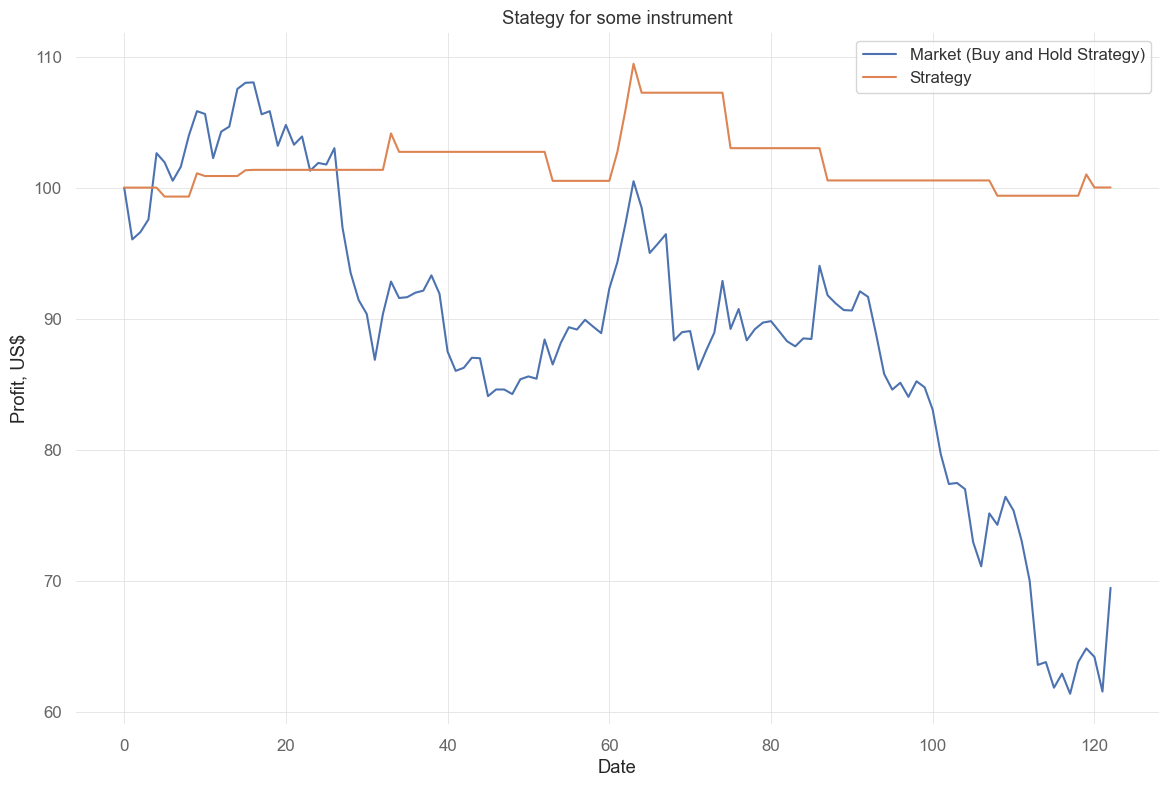

In [223]:
strategy_tester.plot_strategy('Stategy for some instrument')
strategy_tester.basic_metrics()